In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In this study, we aim to utilize a CNN-based model for measuring similarity and generating an adjacency matrix. Then, we will cluster different stock markets using popular clustering algorithms such as $K-means$ and $Hierarchical$ clustering.

### Design the Model :

# <img src="./pic/2.png" width="2000"/>

In [2]:
class TSC_CNN(nn.Module):
    def __init__(self):
        super(TSC_CNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=8,padding='same')
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        self.linear = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.global_avg_pool(x)

        x = x.view(x.size(0), -1)

        x = self.linear(x)

        return x

# Create an instance of the CNN model
model = TSC_CNN().to(device=device)

# Print the model's architecture
print(model)

TSC_CNN(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


In [3]:
test_sample = torch.rand(1,1,1000).to(device=device)

$Input$ of the model is a time series and $output$ of the model is a scaler  (one neuron with linear activation function in output layer ).

In [4]:
model(test_sample)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,


tensor([[0.0197]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Prepair Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
reduced_indices = np.load('/content/drive/My Drive/Data/ProcessedData/World/Names/3300_names_id.npy')

In [7]:
reduced_indices

array([   1,    3,    4, ..., 5413, 5415, 5416])

In [8]:
My_Dataset = pd.read_csv('/content/drive/My Drive/Data/ProcessedData/World/TimeSeries_long.csv')

In [9]:
My_Dataset = My_Dataset.drop(My_Dataset.columns[0], axis=1)

In [10]:
My_Dataset = My_Dataset.iloc[:, reduced_indices]


In [11]:
My_Dataset.head()

,CGAU,US.MI,001979.SZ,KRC,TRUE.BK,CEZ.PR,SW.PA,AMBER.NS,WAWI.OL,PAM,...,REPCOHOME.NS,9533.T,MEG.TO,4401.T,ITUB,9983.T,AKSO.OL,RPOWER.NS,EDIT,0267.HK
0,4.671418,1.338275,21.845114,54.933414,5.928491,329.695221,87.676926,1225.365479,60.797691,62.259998,...,571.019958,3255.302490,5.31,1668.493896,6.516191,13928.928711,44.639999,42.599998,33.980000,9.915198
1,4.426983,1.301866,20.424944,54.323784,5.746075,320.239319,87.248276,1201.038696,59.852154,65.489998,...,575.552673,3035.736816,5.17,1615.539917,6.765031,13168.732422,43.599998,40.650002,35.070000,9.352400
2,4.463195,1.314003,18.390425,54.348499,5.746075,328.434418,88.516373,1196.701660,60.703136,63.799999,...,573.382751,3054.829346,5.02,1676.571411,6.469798,12983.174805,44.790001,40.799999,36.669998,9.269635
3,4.589940,1.294322,17.975546,52.494865,5.837283,322.760925,88.123436,1194.109375,60.230373,61.139999,...,569.525146,3059.602295,5.65,1728.627808,6.372791,12890.394531,45.439999,42.200001,33.279999,9.319293
4,4.508461,1.314003,16.834621,53.920101,5.837283,326.543243,87.819801,1190.570068,59.095737,59.000000,...,567.210693,3021.416992,5.46,1710.677368,6.524626,12414.525391,44.919998,44.900002,33.689999,8.971682


In [12]:
columns = My_Dataset.columns
# My_Dataset = My_Dataset['Adj Close'].drop(0).drop(1)
# My_Dataset.index = np.arange(len(My_Dataset.index.tolist()))
My_Dataset.columns = [f'stock {i+1}' for i in range(len(columns))]
# My_Dataset = My_Dataset

In [13]:
My_Dataset.head()

,stock 1,stock 2,stock 3,stock 4,stock 5,stock 6,stock 7,stock 8,stock 9,stock 10,...,stock 3285,stock 3286,stock 3287,stock 3288,stock 3289,stock 3290,stock 3291,stock 3292,stock 3293,stock 3294
0,4.671418,1.338275,21.845114,54.933414,5.928491,329.695221,87.676926,1225.365479,60.797691,62.259998,...,571.019958,3255.302490,5.31,1668.493896,6.516191,13928.928711,44.639999,42.599998,33.980000,9.915198
1,4.426983,1.301866,20.424944,54.323784,5.746075,320.239319,87.248276,1201.038696,59.852154,65.489998,...,575.552673,3035.736816,5.17,1615.539917,6.765031,13168.732422,43.599998,40.650002,35.070000,9.352400
2,4.463195,1.314003,18.390425,54.348499,5.746075,328.434418,88.516373,1196.701660,60.703136,63.799999,...,573.382751,3054.829346,5.02,1676.571411,6.469798,12983.174805,44.790001,40.799999,36.669998,9.269635
3,4.589940,1.294322,17.975546,52.494865,5.837283,322.760925,88.123436,1194.109375,60.230373,61.139999,...,569.525146,3059.602295,5.65,1728.627808,6.372791,12890.394531,45.439999,42.200001,33.279999,9.319293
4,4.508461,1.314003,16.834621,53.920101,5.837283,326.543243,87.819801,1190.570068,59.095737,59.000000,...,567.210693,3021.416992,5.46,1710.677368,6.524626,12414.525391,44.919998,44.900002,33.689999,8.971682


---
---

Load dataset :

Dataset :

 300-day data of 50 large US stocks

In [ ]:
# stock_names = np.array([i.split(':')[0] for i in My_Dataset.columns.tolist()])
stock_names = np.array(columns)

In [ ]:
stock_names

array(['OMER', 'CGAU', 'BFC', ..., 'EDIT', '0267.HK', 'CPF'], dtype=object)

In this study , we use only **Adj Close** price of each stock for community detection  .

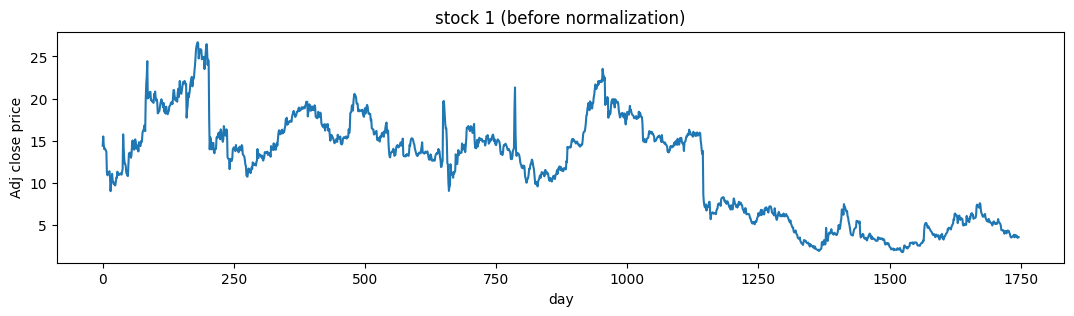

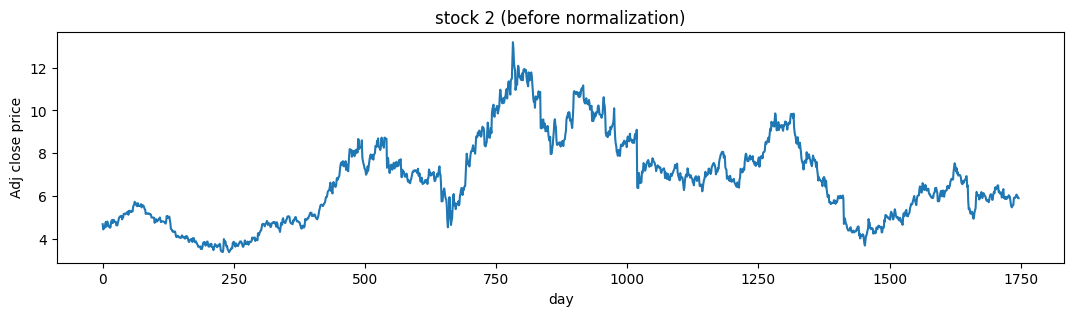

In [ ]:
plt.figure(figsize=(13,3))
plt.plot(My_Dataset['stock 1']);
plt.xlabel('day')
plt.ylabel('Adj close price')
plt.title('stock 1 (before normalization)')

plt.figure(figsize=(13,3))
plt.plot(My_Dataset['stock 2']);
plt.xlabel('day')
plt.ylabel('Adj close price')
plt.title('stock 2 (before normalization)');

Now, we use the percentage of price changes (instead of the price itself) as data for clustering .

In [14]:
My_Dataset_return  = My_Dataset.pct_change()
My_Dataset_return = My_Dataset_return[1:]

In [15]:
My_Dataset_return.max().max()

1007.7787704582213

In [16]:
My_Dataset_return.head()

,stock 1,stock 2,stock 3,stock 4,stock 5,stock 6,stock 7,stock 8,stock 9,stock 10,...,stock 3285,stock 3286,stock 3287,stock 3288,stock 3289,stock 3290,stock 3291,stock 3292,stock 3293,stock 3294
1,-0.052326,-0.027206,-0.065011,-0.011098,-0.030769,-0.028681,-0.004889,-0.019853,-0.015552,0.051879,...,0.007938,-0.067449,-0.026365,-0.031738,0.038188,-0.054577,-0.023298,-0.045775,0.032078,-0.056761
2,0.008180,0.009322,-0.099610,0.000455,0.000000,0.025591,0.014534,-0.003611,0.014218,-0.025805,...,-0.003770,0.006289,-0.029014,0.037778,-0.043641,-0.014091,0.027294,0.003690,0.045623,-0.008850
3,0.028398,-0.014978,-0.022560,-0.034106,0.015873,-0.017274,-0.004439,-0.002166,-0.007788,-0.041693,...,-0.006728,0.001562,0.125498,0.031049,-0.014994,-0.007146,0.014512,0.034314,-0.092446,0.005357
4,-0.017752,0.015205,-0.063471,0.027150,0.000000,0.011719,-0.003446,-0.002964,-0.018838,-0.035002,...,-0.004064,-0.012480,-0.033628,-0.010384,0.023826,-0.036917,-0.011444,0.063981,0.012320,-0.037300
5,0.040161,-0.001331,0.021485,-0.007334,-0.005208,-0.006435,0.010033,0.000279,0.016000,0.022486,...,0.004591,0.000000,0.006105,0.000000,0.006895,0.000000,0.015732,0.036377,-0.016622,0.001230


In [17]:
def prepair_input(df, col_index):          # prepair each column of DataFrame for feed to network.
    return torch.tensor(df[f'stock {col_index}'].to_numpy().reshape(1,1,-1).tolist()).to(device=device)

In the similarity measurement algorithm, since the data has
no labels, in order to complete the training of the network,
the training data labels are set to 0 (that is, the training
data is used as the origin of other untrained data).

 To avoid
those different categories of time series are set to the same
label (0) during one training process, only one time series
can be trained at the same time, then the output of the trained
network can be used as the distance between the input data
and the training data (origin).

 However, the output can only
be used to indicate the similarity between the input data and
the current training data, and it cannot be judged whether
the different input data is similar. Therefore, each data in the
dataset need to be trained separately.

In [23]:
def model_initializer(learning_rate=0.0001):
    model =  TSC_CNN().to(device=device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    return model,criterion,optimizer

def trainer(My_Dataset,model,criterion,optimizer,
            num_epochs=5000,
            stock_train_index=1):

    data = prepair_input(My_Dataset,stock_train_index)

    # Train Network
    for epoch in range(num_epochs):
        model.train()
        # forward
        scores = model(data)
        loss = criterion(scores, torch.zeros(1).unsqueeze(-1).to(device=device))
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()),
        #     f", Test output = {scores.item()}")
    return model

E_elements = []

def E_generator(num_node,My_Dataset):
    E = np.zeros((num_node,num_node))
    counter = 0
    for i in range(num_node):
        bad_model,criterion,optimizer = model_initializer()
        bad_model = trainer(My_Dataset,bad_model,criterion,optimizer,stock_train_index=i+1)

        for j in range(num_node):
        # Evaluation on test data
            inputs  = prepair_input(My_Dataset,j+1)

            bad_model.eval()

            with torch.no_grad():
                output = bad_model(inputs).item()

            E[i,j] = output
            print(output , '   >>>   ',i,' , ',j)
            print('='*20)
            E_elements.append(output)


        if i % 20 == 0:
            np.save(f'/content/drive/My Drive/Data/ProcessedData/World/CNN_data/arr_{counter}',np.array(E_elements))
            counter += 1
            print('Done !')

    return E


generate $E-matrix$ :

### Algorithm 1

In [24]:
def T_generator(num_node,E_mat):
    T_mat = np.zeros((num_node,num_node))
    for k in range(num_node):
        for j in range(num_node):
            for i in range(num_node):
                if ((E_mat[i,k]-E_mat[0,k]) / (E_mat[i,j]-E_mat[0,j])) > 0 :
                    T_mat[k,j] = T_mat[k,j] + 1

    return T_mat/T_mat.max()

Now, using the above algorithm and $E-matrix$, we generate the adjacency matrix ($T-matrix$):

In [25]:
num_epochs = 200
learning_rate = 0.001


In [26]:
len(My_Dataset_return.columns)

3294

In [27]:
# from IPython.display import Javascript  # Restrict height of output cell.
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

E_mat_return = E_generator(len(My_Dataset_return.columns),My_Dataset_return)

Streaming output truncated to the last 5000 lines.
-0.04741228371858597    >>>    121  ,  242
0.008203722536563873    >>>    121  ,  243
0.04591762274503708    >>>    121  ,  244
0.00717153400182724    >>>    121  ,  245
0.035819731652736664    >>>    121  ,  246
0.019778631627559662    >>>    121  ,  247
0.038251690566539764    >>>    121  ,  248
-0.010752640664577484    >>>    121  ,  249
0.03613179177045822    >>>    121  ,  250
0.03486787527799606    >>>    121  ,  251
0.010240428149700165    >>>    121  ,  252
-0.07942167669534683    >>>    121  ,  253
-0.0769764706492424    >>>    121  ,  254
0.02019955962896347    >>>    121  ,  255
-0.03173685818910599    >>>    121  ,  256
0.04311465471982956    >>>    121  ,  257
-0.09732223302125931    >>>    121  ,  258
0.045631103217601776    >>>    121  ,  259
0.04594295471906662    >>>    121  ,  260
-0.01808827370405197    >>>    121  ,  261
-0.05585659295320511    >>>    121  ,  262
0.03238164633512497    >>>    121  ,  263
0.052657447

KeyboardInterrupt: ignored

In [ ]:
world_ret_adj_matrix = T_generator(len(My_Dataset_return.columns),E_mat=E_mat_return)

In [ ]:
# np.save('E_mat_usa_ret',E_mat_return)
np.save('adj_mat_usa_ret',world_ret_adj_matrix)

### Clustering using Ward's method :

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram,cut_tree
import matplotlib.pyplot as plt
import sys

In [ ]:
def ward(distance_matrix,labels):
    # Perform hierarchical clustering using Ward's Method
    Z = linkage(distance_matrix, method='ward')

    # Plot the dendrogram
    plt.figure(figsize=(18,8))
    dendrogram(Z,labels=labels)
    plt.title("Dendrogram")
    plt.xlabel("Nodes")
    plt.ylabel("Distance")
    plt.show()

In [ ]:
def adj_to_distance(adj_mat):    # convert adjacency(similarity) matrix to distance matrix
    dist_mat = np.exp(-adj_mat)
    np.fill_diagonal(dist_mat,0)
    return dist_mat

In [ ]:
# ward(adj_to_distance((USA_adj_matrix)))

In [ ]:
plt.figure(figsize=(13,2))
plt.plot(My_Dataset['stock 18']);
plt.title(stock_names[17]);

plt.figure(figsize=(13,2))
plt.plot(My_Dataset['stock 38']);
plt.title(stock_names[37]);


plt.figure(figsize=(13,2))
plt.plot(My_Dataset['stock 24']);
plt.title(stock_names[23]);


plt.figure(figsize=(13,2))
plt.plot(My_Dataset['stock 43'],color='r');
plt.title(stock_names[42]);

### Clustering using KMeans method :

In [ ]:
from sklearn.cluster import KMeans

def my_KMeans(distance_matrix):

    k = 7  # Number of clusters
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(distance_matrix)

    # Get the cluster labels for each node
    cluster_labels = kmeans.labels_

    # Print the results
    for i in range(k):
        cluster_points = [j for j, cluster in enumerate(cluster_labels) if cluster == i]
        print(f"Cluster {i+1}:")
        print(f"Data points: {cluster_points}")
        print()

In [ ]:
# my_KMeans(adj_to_distance(USA_adj_matrix))

---

## Two-step clustering    (incomplete)

Now we want to cluster the stock markets with the help of a **Convolutional Neural Network** and the similarity matrix that we obtained in the previous section :

In [ ]:
def dict_creator(lst):
    dict_ = {}
    for i in range(len(lst)):
        dict_[i] = lst[i]

    return dict_

def list_of_length(arr):
    return np.array([len(i) for i in arr])

In [ ]:
def Cluster_Generation(T,treshold,K):
    n = T.shape[0]
    B = []
    alpha = [0 for _ in range(n)]
    for i in range(n):
        B = [i,]
        alpha[i] = [i,]
        while len(B) > 0 :
            for k in range(len(B)):
                mydict = dict_creator(T[B[k]])
                sorted_dict = dict(sorted(mydict.items(), key=lambda x: x[1],reverse=True))
                G = list(sorted_dict.keys())[:K]
                for j in range(len(G)):
                    if T[i,G[j]] >= treshold :
                        B.append(G[j])
            # print(type(alpha[i]),alpha[i])
            B = list(set(B) - set.intersection(set(B),set(alpha[i])))
            B = list(set(B))
            alpha[i] = alpha[i] + B

    return alpha

In [ ]:
from re import X
from itertools import permutations

def create_permutations(lst):
    # Generate permutations of length 2
    perm = permutations(lst, 2)

    # Print each permutation, excluding duplicates
    x = []
    for p in perm:
        if set(p) not in x:
          x.append(set(p))
        #   print(p)
    return x
# Example usage
my_list = [1, 2, 3, 4]  # Replace with your own list
per = create_permutations(my_list)
per

[{1, 2}, {1, 3}, {1, 4}, {2, 3}, {2, 4}, {3, 4}]

In [ ]:
def merg_clusers(arr):

    def append_(list_,elem):
        if elem not in list_:
            list_.append(elem)
        return list_

    def not_subset(i,arr):
        is_subset = True
        for j in arr:
            if len(set(i) - set(j)) == 0 and i != j:
                is_subset = False
        return is_subset

    merged_alpha = []
    num_cluster = len(arr)
    for pair in create_permutations(list(range(num_cluster))):
        i,j = list(pair)[0], list(pair)[1]
        intersection_len = len(set(arr[i]) & set(arr[j]))
        min_len = min(len(arr[i]), len(arr[j]))
        # append_(merged_alpha,arr[i])
        # append_(merged_alpha,arr[j])

        if intersection_len > min_len / 2:
            append_(merged_alpha,list(set(arr[i]) | set(arr[j])))

    for i in arr:
        # print(i,not_subset(i,merged_alpha))
        if not_subset(i,merged_alpha):
            merged_alpha.append(i)

    return merged_alpha


In [ ]:
alpha = [[1, 2, 3], [3, 4, 5], [6, 7, 8,9,10], [8, 9, 10,11]]

merg_clusers(alpha)

[[6, 7, 8, 9, 10, 11], [1, 2, 3], [3, 4, 5]]

In [ ]:
def return_C_largest_clusters(C,arr):
    length = list_of_length(arr)
    sorted_indices = np.argsort(length)[::-1]
    indices_of_largest = sorted_indices[:C]
    # print(indices_of_largest)

    return [arr[i] for i in indices_of_largest]

### For **Iran Stocks** adjcency matrix :

<Axes: ylabel='Count'>

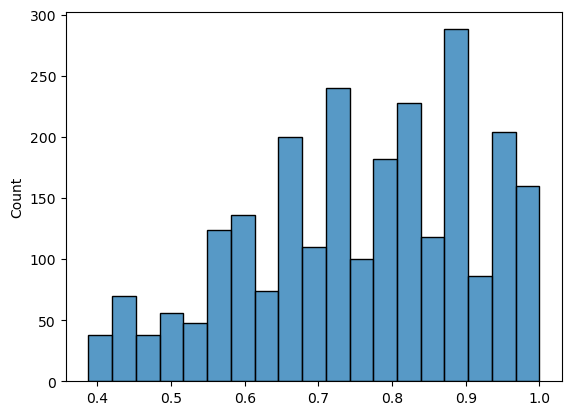

In [ ]:
sns.histplot(Iran_adj_matrix.reshape(-1))

In [ ]:
a = Cluster_Generation(Iran_adj_matrix,0.8,3)
a

In [ ]:
merg_clusers(a)

In [ ]:
return_C_largest_clusters(5,merg_clusers(a))

[[1, 35, 37, 10, 42, 12, 45, 14, 16, 17, 24],
 [3, 4, 5, 6, 7, 8, 40, 38, 20, 26, 29],
 [0, 1, 35, 37, 42, 10, 12, 45, 14, 16, 17],
 [1, 35, 37, 42, 10, 12, 45, 14, 16, 17, 31],
 [1, 10, 12, 14, 16, 17, 35, 37, 42, 45, 47]]

In [ ]:
def Preliminary_clustering(adj_matrix,treshold=0.8,K=3):
    a = Cluster_Generation(adj_matrix,treshold,K)
    ...


### Design the Model :

In [ ]:
class CNN_Clustering(nn.Module):
    def __init__(self,n_clusters):
        super(CNN_Clustering, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=8,padding='same')
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        self.linear = nn.Linear(128, n_clusters)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.global_avg_pool(x)

        x = x.view(x.size(0), -1)

        x = self.softmax(self.linear(x))

        return x

# Create an instance of the CNN model
my_model = CNN_Clustering(7).to(device=device)

# Print the model's architecture
print(my_model)

CNN_Clustering(
  (conv1): Conv1d(1, 128, kernel_size=(8,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (linear): Linear(in_features=128, out_features=7, bias=True)
  (softmax): Softmax(dim=None)
)
